c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0061 - val_loss: 0.0035
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 9.8578e-04 - val_loss: 0.0011
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 8.1096e-04 - val_loss: 9.3279e-04
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 8.6378e-04 - val_loss: 0.0015
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 7.4804e-04 - val_loss: 7.7228e-04
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 6.8629e-04 - val_loss: 9.8612e-04
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 6.9928e-04 - val_loss: 7.2465e-04
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 6.0723e-04 - val_loss: 0.0011
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 7.5857e-04 - val_loss: 0.0011
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 6.4559e-04 - val_lo

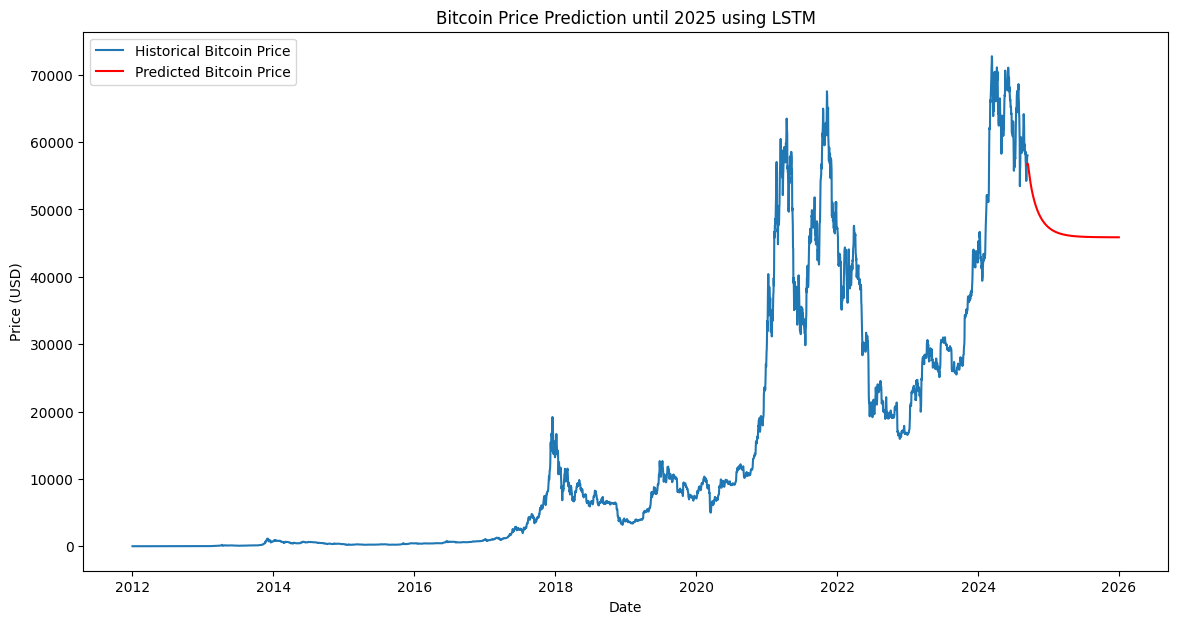

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import datetime

# Load the dataset
df = pd.read_csv('./btcusd_1-min_data.csv')

# Calculate the weighted price as the average of High, Low, and Close
if 'High' in df.columns and 'Low' in df.columns and 'Close' in df.columns:
    df['weighted_price'] = (df['High'] + df['Low'] + df['Close']) / 3
else:
    print("Required columns ('High', 'Low', 'Close') not found in the dataset.")

# Convert Timestamp to datetime and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Resample to daily frequency and compute mean values
df_daily = df.resample('D').mean()

# Drop missing values
df_daily.dropna(inplace=True)

# Select the 'weighted_price' column for prediction
data = df_daily[['weighted_price']].values

# Normalize the data (LSTM performs better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create a dataset for LSTM
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])  # Past 'look_back' values as input
        Y.append(dataset[i, 0])              # Current value as target
    return np.array(X), np.array(Y)

# Set the look_back period (e.g., 60 days)
look_back = 60

# Create datasets for LSTM (use the entire data for training since we are forecasting the future)
X_train, Y_train = create_dataset(scaled_data, look_back)

# Reshape the data to [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to avoid overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for predicting the price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2)

# Predict future prices until the end of 2025
# To predict future values, we'll use the last 'look_back' data points to start the prediction process
last_60_days = scaled_data[-look_back:]
future_predictions = []
future_dates = pd.date_range(df_daily.index[-1], '2025-12-31')

# Loop to predict prices for each future day
for i in range(len(future_dates)):
    # Reshape the input to be compatible with LSTM input shape
    input_seq = np.reshape(last_60_days, (1, look_back, 1))
    
    # Predict the next day price
    predicted_price = model.predict(input_seq)
    
    # Store the prediction
    future_predictions.append(predicted_price[0, 0])
    
    # Update the last_60_days to include the new prediction
    last_60_days = np.vstack([last_60_days[1:], predicted_price])

# Inverse scale the predictions to return to original price values
predicted_prices_2025 = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame to store the predicted prices with corresponding dates
predicted_df = pd.DataFrame(predicted_prices_2025, index=future_dates, columns=['Predicted Price'])

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['weighted_price'], label='Historical Bitcoin Price')
plt.plot(predicted_df.index, predicted_df['Predicted Price'], label='Predicted Bitcoin Price', color='red')
plt.title('Bitcoin Price Prediction until 2025 using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


Epoch 1/20


c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0099 - val_loss: 0.0038
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 7.4939e-04 - val_loss: 0.0018
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 7.6348e-04 - val_loss: 0.0018
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 8.4394e-04 - val_loss: 8.7279e-04
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 6.0595e-04 - val_loss: 8.4209e-04
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 8.2632e-04 - val_loss: 7.3840e-04
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 6.5264e-04 - val_loss: 6.9424e-04
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 5.9854e-04 - val_loss: 0.0017
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 6.3897e-04 - val_loss: 0.0011
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 6.4059e-04 - val_loss: 9.7760e

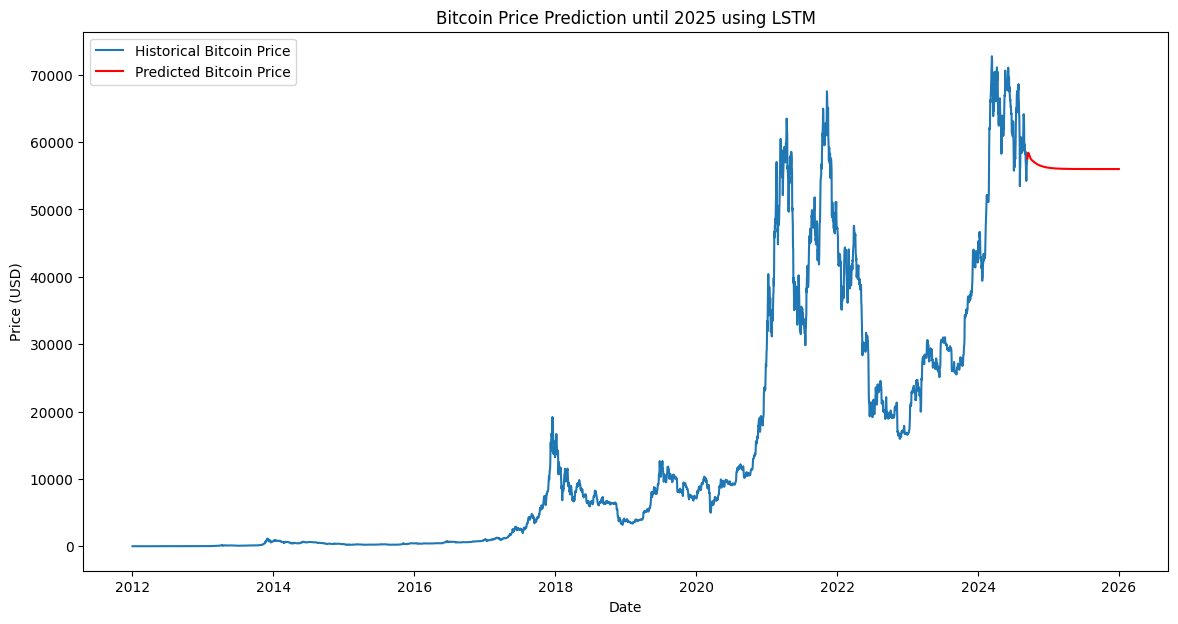

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import datetime

# Load the dataset
df = pd.read_csv('./btcusd_1-min_data.csv')

# Calculate the weighted price as the average of High, Low, and Close
if 'High' in df.columns and 'Low' in df.columns and 'Close' in df.columns:
    df['weighted_price'] = (df['High'] + df['Low'] + df['Close']) / 3
else:
    print("Required columns ('High', 'Low', 'Close') not found in the dataset.")

# Convert Timestamp to datetime and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Resample to daily frequency and compute mean values
df_daily = df.resample('D').mean()

# Drop missing values
df_daily.dropna(inplace=True)

# Select the 'weighted_price' column for prediction
data = df_daily[['weighted_price']].values

# Normalize the data (LSTM performs better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create a dataset for LSTM
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])  # Past 'look_back' values as input
        Y.append(dataset[i, 0])              # Current value as target
    return np.array(X), np.array(Y)

# Set the look_back period (e.g., 60 days)
look_back = 60

# Create datasets for LSTM (use the entire data for training since we are forecasting the future)
X_train, Y_train = create_dataset(scaled_data, look_back)

# Reshape the data to [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to avoid overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for predicting the price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2)

# Predict future prices until the end of 2025
# To predict future values, we'll use the last 'look_back' data points to start the prediction process
last_60_days = scaled_data[-look_back:]
future_predictions = []
future_dates = pd.date_range(df_daily.index[-1], '2025-12-31')

# Loop to predict prices for each future day
for i in range(len(future_dates)):
    # Reshape the input to be compatible with LSTM input shape
    input_seq = np.reshape(last_60_days, (1, look_back, 1))
    
    # Predict the next day price
    predicted_price = model.predict(input_seq)
    
    # Store the prediction
    future_predictions.append(predicted_price[0, 0])
    
    # Update the last_60_days to include the new prediction
    last_60_days = np.vstack([last_60_days[1:], predicted_price])

# Inverse scale the predictions to return to original price values
predicted_prices_2025 = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame to store the predicted prices with corresponding dates
predicted_df = pd.DataFrame(predicted_prices_2025, index=future_dates, columns=['Predicted Price'])

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['weighted_price'], label='Historical Bitcoin Price')
plt.plot(predicted_df.index, predicted_df['Predicted Price'], label='Predicted Bitcoin Price', color='red')
plt.title('Bitcoin Price Prediction until 2025 using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


Epoch 1/1000


c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0115 - val_loss: 0.0013
Epoch 2/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 9.3683e-04 - val_loss: 0.0012
Epoch 3/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 9.7000e-04 - val_loss: 0.0011
Epoch 4/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 7.2736e-04 - val_loss: 0.0010
Epoch 5/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 8.0732e-04 - val_loss: 0.0015
Epoch 6/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 7.1119e-04 - val_loss: 0.0018
Epoch 7/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 8.1141e-04 - val_loss: 7.5200e-04
Epoch 8/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 6.1196e-04 - val_loss: 8.5280e-04
Epoch 9/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 6.6020e-04 - val_loss: 7.0763e-04
Epoch 10/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 7.1285e-04 - val_loss: 7.1238e-04
Epoch 11/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 6.3020

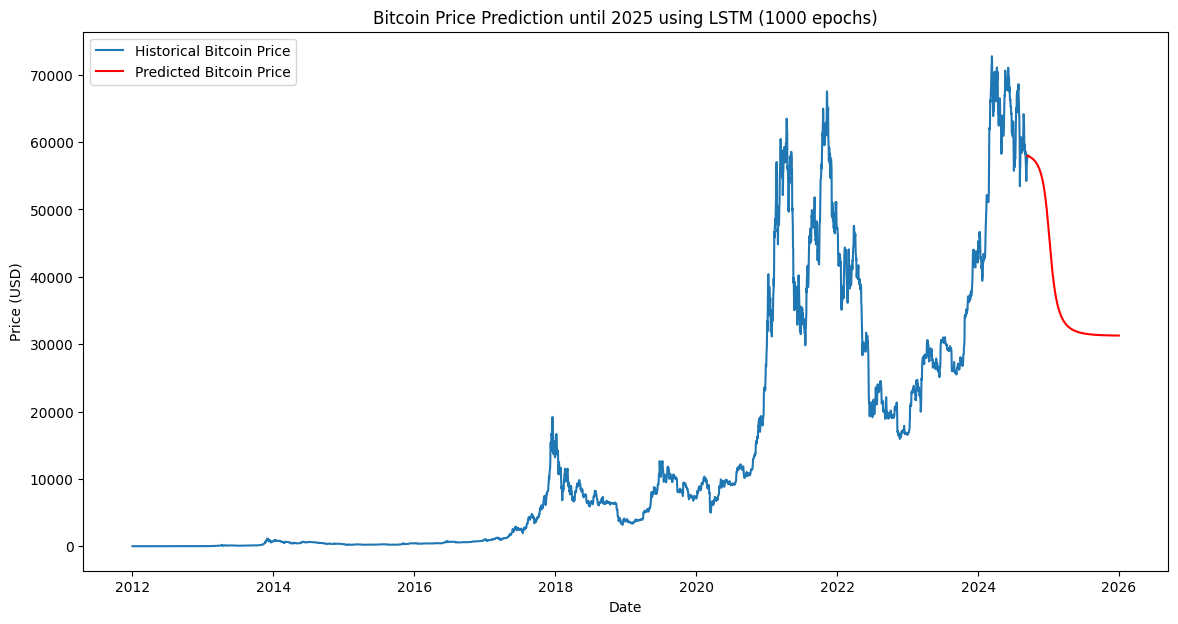

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import datetime

# Load the dataset
df = pd.read_csv('./btcusd_1-min_data.csv')

# Calculate the weighted price as the average of High, Low, and Close
if 'High' in df.columns and 'Low' in df.columns and 'Close' in df.columns:
    df['weighted_price'] = (df['High'] + df['Low'] + df['Close']) / 3
else:
    print("Required columns ('High', 'Low', 'Close') not found in the dataset.")

# Convert Timestamp to datetime and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Resample to daily frequency and compute mean values
df_daily = df.resample('D').mean()

# Drop missing values
df_daily.dropna(inplace=True)

# Select the 'weighted_price' column for prediction
data = df_daily[['weighted_price']].values

# Normalize the data (LSTM performs better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create a dataset for LSTM
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])  # Past 'look_back' values as input
        Y.append(dataset[i, 0])              # Current value as target
    return np.array(X), np.array(Y)

# Set the look_back period (e.g., 60 days)
look_back = 60

# Create datasets for LSTM (use the entire data for training since we are forecasting the future)
X_train, Y_train = create_dataset(scaled_data, look_back)

# Reshape the data to [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to avoid overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for predicting the price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model for 1000 epochs
history = model.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_split=0.2)

# Predict future prices until the end of 2025
# To predict future values, we'll use the last 'look_back' data points to start the prediction process
last_60_days = scaled_data[-look_back:]
future_predictions = []
future_dates = pd.date_range(df_daily.index[-1], '2025-12-31')

# Loop to predict prices for each future day
for i in range(len(future_dates)):
    # Reshape the input to be compatible with LSTM input shape
    input_seq = np.reshape(last_60_days, (1, look_back, 1))
    
    # Predict the next day price
    predicted_price = model.predict(input_seq)
    
    # Store the prediction
    future_predictions.append(predicted_price[0, 0])
    
    # Update the last_60_days to include the new prediction
    last_60_days = np.vstack([last_60_days[1:], predicted_price])

# Inverse scale the predictions to return to original price values
predicted_prices_2025 = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame to store the predicted prices with corresponding dates
predicted_df = pd.DataFrame(predicted_prices_2025, index=future_dates, columns=['Predicted Price'])

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['weighted_price'], label='Historical Bitcoin Price')
plt.plot(predicted_df.index, predicted_df['Predicted Price'], label='Predicted Bitcoin Price', color='red')
plt.title('Bitcoin Price Prediction until 2025 using LSTM (1000 epochs)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [5]:
model.save('bitcoin_lstm_model.h5')  # Save the trained LSTM model


Epoch 1/1000


c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0244 - val_loss: 0.0101
Epoch 2/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0080 - val_loss: 0.0089
Epoch 3/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 4/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0028 - val_loss: 0.0051
Epoch 5/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 6/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 7/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0015 - val_loss: 0.0059
Epoch 8/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 9/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 10/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 11/1000
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 12/1000
115/115 ━━━━━━━━━━

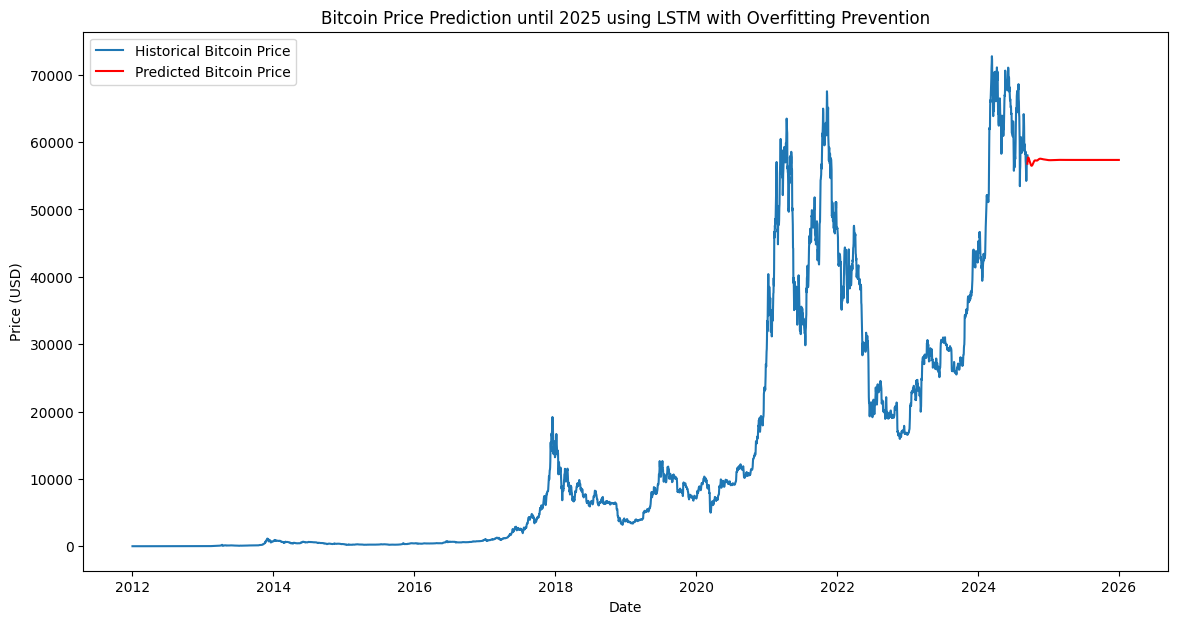

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('./btcusd_1-min_data.csv')

# Calculate the weighted price as the average of High, Low, and Close
if 'High' in df.columns and 'Low' in df.columns and 'Close' in df.columns:
    df['weighted_price'] = (df['High'] + df['Low'] + df['Close']) / 3
else:
    print("Required columns ('High', 'Low', 'Close') not found in the dataset.")

# Convert Timestamp to datetime and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Resample to daily frequency and compute mean values
df_daily = df.resample('D').mean()

# Drop missing values
df_daily.dropna(inplace=True)

# Select the 'weighted_price' column for prediction
data = df_daily[['weighted_price']].values

# Normalize the data (LSTM performs better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create a dataset for LSTM
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])  # Past 'look_back' values as input
        Y.append(dataset[i, 0])              # Current value as target
    return np.array(X), np.array(Y)

# Set the look_back period (e.g., 60 days)
look_back = 60

# Create datasets for LSTM (use the entire data for training since we are forecasting the future)
X_train, Y_train = create_dataset(scaled_data, look_back)

# Reshape the data to [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model with increased dropout and reduced complexity
model = Sequential()

# First LSTM layer with Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))  # Increased dropout rate to 30%

# Second LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))  # Increased dropout rate to 30%

# Output layer for predicting the price
model.add(Dense(units=1, kernel_regularizer='l2'))  # Added L2 regularization

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model for 1000 epochs with early stopping
history = model.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict future prices until the end of 2025
# To predict future values, we'll use the last 'look_back' data points to start the prediction process
last_60_days = scaled_data[-look_back:]
future_predictions = []
future_dates = pd.date_range(df_daily.index[-1], '2025-12-31')

# Loop to predict prices for each future day
for i in range(len(future_dates)):
    # Reshape the input to be compatible with LSTM input shape
    input_seq = np.reshape(last_60_days, (1, look_back, 1))
    
    # Predict the next day price
    predicted_price = model.predict(input_seq)
    
    # Store the prediction
    future_predictions.append(predicted_price[0, 0])
    
    # Update the last_60_days to include the new prediction
    last_60_days = np.vstack([last_60_days[1:], predicted_price])

# Inverse scale the predictions to return to original price values
predicted_prices_2025 = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame to store the predicted prices with corresponding dates
predicted_df = pd.DataFrame(predicted_prices_2025, index=future_dates, columns=['Predicted Price'])

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['weighted_price'], label='Historical Bitcoin Price')
plt.plot(predicted_df.index, predicted_df['Predicted Price'], label='Predicted Bitcoin Price', color='red')
plt.title('Bitcoin Price Prediction until 2025 using LSTM with Overfitting Prevention')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
